In [6]:
import numpy as np
from glob import glob

In [7]:
import librosa.display
import IPython

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import tensorflow as tf
from tensorflow.keras import losses

2022-11-30 15:30:29.169139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [97]:
data_dir = '/Users/felixm/Downloads/snare_specs'

In [98]:
audiofiles = glob(data_dir + '/*.npy')

In [99]:
def load_data(path):
    X = []
    
    audiofiles = glob(data_dir + '/*.wav.npy')
    
    for file in audiofiles:
        
        X.append(np.load(file))
        
        
    return np.array(X)

In [100]:
data = load_data(data_dir)

In [103]:
def remove_nans(data):
    if np.isnan(data).sum() > 0:
        a = data.shape[1]
        b = data.shape[2]
        good_data_total = int(data.shape[0] - (np.isnan(data).sum() / (a * b)))
        data = data[~np.isnan(data)]
        data = data.reshape(good_data_total, a,b)
        return data
    return data



In [104]:
data = remove_nans(data)

In [105]:
data.shape

(6056, 256, 188)

In [71]:
np.isnan(data).sum() / 48128

3.0

In [73]:
data = data[~np.isnan(data)]


In [76]:
data = data.reshape(6056,256,188)

In [77]:
data.shape

(6056, 256, 188)

In [68]:
data.shape[0] * data.shape[1] * data.shape[2]

291607552

In [69]:
data.shape

(6059, 256, 188)

In [70]:
256 * 188

48128

In [151]:
X_train = data[:5000, :, :]

In [152]:
X_valid = data[5000:6000, :, :]

imports

Sampling layer which is called later in the function, takes in mean and log_var and randomly samples the coding from normal distribution.

In [153]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var/2) + mean

In [154]:
codings_size = 10

encoder, mean and log_var take in same input from second layer hense not being sequential

In [155]:
inputs = layers.Input(shape=[256,188])
z = layers.Flatten()(inputs)
z = layers.Dense(150, activation='selu')(z)
z = layers.Dense(100, activation='selu')(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean,codings_log_var])
variational_encoder = Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder

In [156]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation='selu')(decoder_inputs)
x = layers.Dense(150, activation='selu')(x)
x = layers.Dense(256 * 188, activation='sigmoid')(x)
outputs = layers.Reshape([256, 188])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [157]:
_,_,codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

custom KL Loss

In [158]:
loss=losses.kullback_leibler_divergence

In [159]:
latent_loss = -0.5 * k.sum(
1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean),
axis=-1)
variational_ae.add_loss(k.mean(latent_loss)/256*188)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [160]:
from tensorflow.keras.callbacks import EarlyStopping


In [161]:
es = EarlyStopping(patience=10,restore_best_weights=True)

history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=[X_valid, X_valid], callbacks=[es])

Epoch 1/100
40/40 [==============================] - 13s 270ms/step - loss: 1158025284276827283270614346891264.0000 - val_loss: 1066791296.0000
Epoch 2/100
40/40 [==============================] - 9s 233ms/step - loss: 1040029568.0000 - val_loss: 2191904.0000
Epoch 3/100
40/40 [==============================] - 9s 228ms/step - loss: 221462.0156 - val_loss: 181456.4688
Epoch 4/100
40/40 [==============================] - 9s 226ms/step - loss: 19859.3945 - val_loss: 14496.8340
Epoch 5/100
40/40 [==============================] - 9s 228ms/step - loss: 3052.8503 - val_loss: 1096.0306
Epoch 6/100
40/40 [==============================] - 9s 229ms/step - loss: 404.9983 - val_loss: 26.6940
Epoch 7/100
40/40 [==============================] - 9s 228ms/step - loss: 15.9341 - val_loss: 9.1518
Epoch 8/100
40/40 [==============================] - 9s 230ms/step - loss: 8.4437 - val_loss: 7.2333
Epoch 9/100
40/40 [==============================] - 9s 228ms/step - loss: 7.3998 - val_loss: 7.9999
Epoch

In [174]:
codings = tf.random.normal(shape=[10, codings_size],stddev=4.0)
images = variational_decoder(codings).numpy()

In [175]:
images

array([[[6.09451354e-01, 6.57386899e-01, 6.32312357e-01, ...,
         1.93774179e-02, 1.76618882e-02, 2.14826874e-02],
        [6.97596908e-01, 7.58266926e-01, 7.96365857e-01, ...,
         2.76841596e-02, 2.47396771e-02, 2.47905608e-02],
        [7.39945531e-01, 8.43648136e-01, 8.67413342e-01, ...,
         2.20782533e-02, 2.41801012e-02, 2.65785847e-02],
        ...,
        [4.05116007e-02, 7.03734951e-03, 7.19303172e-03, ...,
         6.74054679e-03, 7.27713481e-03, 8.05951003e-03],
        [4.59136665e-02, 5.92845539e-03, 7.03509059e-03, ...,
         6.26809103e-03, 6.71971356e-03, 8.17373767e-03],
        [4.26951312e-02, 7.89611414e-03, 6.85593579e-03, ...,
         6.74779853e-03, 6.21589413e-03, 7.87863694e-03]],

       [[7.26027787e-01, 8.29576075e-01, 8.06620836e-01, ...,
         1.11673216e-04, 1.76600937e-04, 1.49777698e-04],
        [8.76556039e-01, 9.58467066e-01, 9.57327664e-01, ...,
         1.89431288e-04, 3.14734294e-04, 3.93427588e-04],
        [9.00664568e-01, 

In [21]:
variational_ae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 188)]   0           []                               
                                                                                                  
 model (Functional)             [(None, 100),        7254650     ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 model_1 (Functional)           (None, 256, 188)     7292578     ['model[0][2]']                  
                                                                                            

In [176]:
hop_length = 300
win_length = 1200
# spec = librosa.db_to_amplitude(images[1])

In [189]:
# signal = librosa.istft(spec, n_fft=1200, hop_length=hop_length, win_length=win_length, dtype='float32')
f = librosa.core.spectrum.griffinlim(images[7])


In [190]:
IPython.display.Audio(f, rate=36000)

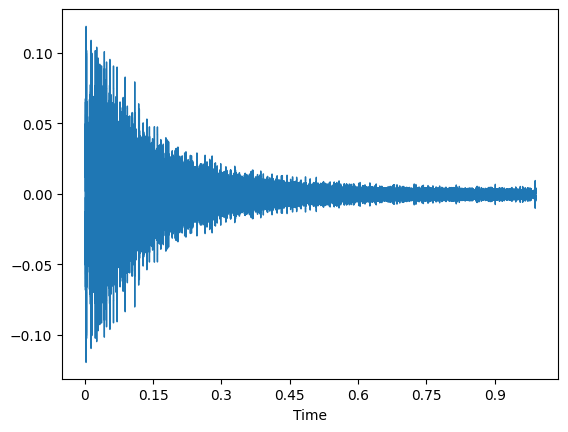

In [191]:
librosa.display.waveshow(f,sr=24000)

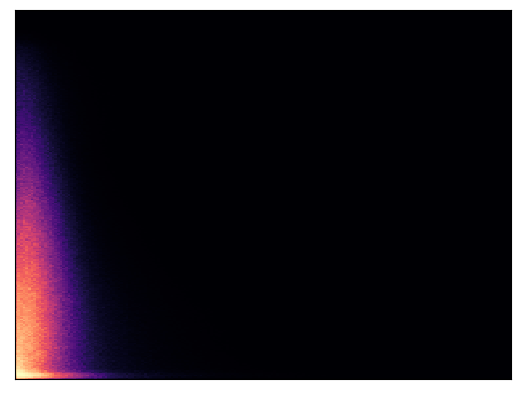

In [192]:
librosa.display.specshow(images[1])

In [27]:
# np.save("/Users/felixm/Downloads/",images)